## import fgm tables


In [ ]:
!pip install gdown
!mkdir ./data
import gdown

def data_import():
  ids = {
      "tables_of_fgm.h5":"1XHPF7hUqT-zp__qkGwHg8noRazRnPqb0"
  }

  url = 'https://drive.google.com/uc?id='

  for title, g_id in ids.items(): 
    try:
      output_file = open("/content/data/" + title, 'wb')
      gdown.download(url + g_id, output_file, quiet=False)
    except IOError as e:
      print(e)
    finally:
      output_file.close()
      
data_import()

Downloading...
From: https://drive.google.com/uc?id=1XHPF7hUqT-zp__qkGwHg8noRazRnPqb0
To: <_io.BufferedWriter name='/content/tables_of_fgm.h5'>
982MB [00:06, 153MB/s]


# Function libaries

## ResBlock

```res_block``` is the backbone of the resnet structure. The resblock has multi branch, bottle neck layer and skip connection build in.  This modularized design has made create deep neural network easy. 

In [2]:
import tensorflow as tf
import keras
from keras.layers import Dense, Activation, Input, BatchNormalization, Dropout, concatenate
from keras import layers

def res_branch(bi, conv_name_base, bn_name_base, scale, input_tensor, n_neuron, stage, block,dp1, bn=False):
    x_1 = Dense(scale * n_neuron, name=conv_name_base + '2a_'+str(bi))(input_tensor)
    if bn:
        x_1 = BatchNormalization(axis=-1, name=bn_name_base + '2a_'+str(bi))(x_1)
    x_1 = Activation('relu')(x_1)
    if dp1>0:
      x_1 = Dropout(dp1)(x_1)
    return x_1

def res_block(input_tensor,scale, n_neuron, stage, block, bn=False,branches=0):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

#     scale = 2
    x = Dense(scale * n_neuron, name=conv_name_base + '2a')(input_tensor)
    if bn:
        x = BatchNormalization(axis=-1, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    dp1=0.
    if dp1 >0:
        x = Dropout(dp1)(x)
    
    branch_list=[x]
    for i in range(branches-1):
        branch_list.append(res_branch(i,conv_name_base, bn_name_base, scale,input_tensor,n_neuron,stage,block,dp1,bn))
    if branches-1 > 0:
        x = Dense(n_neuron, name=conv_name_base + '2b')(concatenate(branch_list,axis=-1))
#         x = Dense(n_neuron, name=conv_name_base + '2b')(layers.add(branch_list))
    else:
        x = Dense(n_neuron, name=conv_name_base + '2b')(x)
    
    if bn:
        x = BatchNormalization(axis=-1, name=bn_name_base + '2b')(x)
    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    if dp1 >0:
        x = Dropout(dp1)(x)

    return x

## data_reader
The ```read_h5_data``` function read the table from the hdf5 file. 

In the FGM case we chose not to scale the input features, since they all falls between 0 and 1. There are a great variety in the output features. In the reaction region close to stoichiometry the gradient in the output properties are great. A good example is the source term for progress variable, which rises from 0 to 1e5. So the output features are first transformed to logrithmic scale and then rearranged between  0 and 1. The outputs are normalised by its variance. This way the output value will be large where the gradient is great. So during training more focus would be put. The same 'focus design' has been put on the loss function selection as well. mse is selected over mae for that the squared error put more weights on the data samples that shows great changes. 

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler


class data_scaler(object):
    def __init__(self):
        self.norm = None
        self.norm_1 = None
        self.std = None
        self.case = None
        self.scale = 1
        self.bias = 1e-20
#         self.bias = 1


        self.switcher = {
            'min_std': 'min_std',
            'std2': 'std2',
            'std_min':'std_min',
            'min': 'min',
            'no':'no',
            'log': 'log',
            'log_min':'log_min',
            'log2': 'log2',
            'tan': 'tan'
        }

    def fit_transform(self, input_data, case):
        self.case = case
        if self.switcher.get(self.case) == 'min_std':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.norm.fit_transform(input_data)
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'std2':
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)
            out = self.norm.fit_transform(out)

        if self.switcher.get(self.case) == 'min':
            self.norm = MinMaxScaler()
            out = self.norm.fit_transform(input_data)

        if self.switcher.get(self.case) == 'no':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = input_data

        if self.switcher.get(self.case) == 'log':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'log_min':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            self.norm = MinMaxScaler()
            out = self.norm.fit_transform(out)

        if self.switcher.get(self.case) == 'log2':
            self.norm = MinMaxScaler()
            self.norm_1 = MinMaxScaler()
            out = self.norm.fit_transform(input_data)
            out = np.log(np.asarray(out) + self.bias)
            out = self.norm_1.fit_transform(out)

        if self.switcher.get(self.case) == 'tan':
            self.norm = MaxAbsScaler()
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)
            out = self.norm.fit_transform(out)
            out = np.tan(out / (2 * np.pi + self.bias))

        return out

    def transform(self, input_data):
        if self.switcher.get(self.case) == 'min_std':
            out = self.norm.transform(input_data)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'std2':
            out = self.std.transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            out = self.std.transform(input_data)
            out = self.norm.transform(out)

        if self.switcher.get(self.case) == 'min':
            out = self.norm.transform(input_data)

        if self.switcher.get(self.case) == 'no':
            out = input_data

        if self.switcher.get(self.case) == 'log':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'log_min':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            out = self.norm.transform(out)

        if self.switcher.get(self.case) == 'log2':
            out = self.norm.transform(input_data)
            out = np.log(np.asarray(out) + self.bias)
            out = self.norm_1.transform(out)

        if self.switcher.get(self.case) == 'tan':
            out = self.std.transform(input_data)
            out = self.norm.transform(out)
            out = np.tan(out / (2 * np.pi + self.bias))

        return out

    def inverse_transform(self, input_data):

        if self.switcher.get(self.case) == 'min_std':
            out = self.std.inverse_transform(input_data)
            out = self.norm.inverse_transform(out)

        if self.switcher.get(self.case) == 'std2':
            out = self.std.inverse_transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            out = self.norm.inverse_transform(input_data)
            out = self.std.inverse_transform(out)

        if self.switcher.get(self.case) == 'min':
            out = self.norm.inverse_transform(input_data)

        if self.switcher.get(self.case) == 'no':
            out = input_data

        if self.switcher.get(self.case) == 'log':
            out = self.std.inverse_transform(input_data)
            out = (np.exp(-out) - self.bias) * self.scale

        if self.switcher.get(self.case) == 'log_min':
            out = self.norm.inverse_transform(input_data)
            out = (np.exp(-out) - self.bias) * self.scale

        if self.switcher.get(self.case) == 'log2':
            out = self.norm_1.inverse_transform(input_data)
            out = np.exp(out) - self.bias
            out = self.norm.inverse_transform(out)

        if self.switcher.get(self.case) == 'tan':
            out = (2 * np.pi + self.bias) * np.arctan(input_data)
            out = self.norm.inverse_transform(out)
            out = self.std.inverse_transform(out)

        return out
      

def read_h5_data(fileName, input_features, labels):
    df = pd.read_hdf(fileName)
    df = df[df['f']<0.45]
    
    input_df=df[input_features]
    in_scaler = data_scaler()
    input_np = in_scaler.fit_transform(input_df.values,'no')

    label_df=df[labels].clip(0)
#     if 'PVs' in labels:
#       label_df['PVs']=np.log(label_df['PVs']+1)
    out_scaler = data_scaler()
    label_np = out_scaler.fit_transform(label_df.values,'std2')

    return input_np, label_np, df, in_scaler, out_scaler

# model

## load data

In [4]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# define the labels
col_labels=['C2H3', 'C2H6', 'CH2', 'H2CN', 'C2H4', 'H2O2', 'C2H', 'CN',
       'heatRelease', 'NCO', 'NNH', 'N2', 'AR', 'psi', 'CO', 'CH4', 'HNCO',
       'CH2OH', 'HCCO', 'CH2CO', 'CH', 'mu', 'C2H2', 'C2H5', 'H2', 'T', 'PVs',
       'O', 'O2', 'N2O', 'C', 'C3H7', 'CH2(S)', 'NH3', 'HO2', 'NO', 'HCO',
       'NO2', 'OH', 'HCNO', 'CH3CHO', 'CH3', 'NH', 'alpha', 'CH3O', 'CO2',
       'CH3OH', 'CH2CHO', 'CH2O', 'C3H8', 'HNO', 'NH2', 'HCN', 'H', 'N', 'H2O',
       'HCCOH', 'HCNN']

# Taking 0 out
col_labels.remove('AR')
col_labels.remove('heatRelease')

# labels = ['T','PVs']
# labels = ['T','CH4','O2','CO2','CO','H2O','H2','OH','psi']
# labels = ['CH2OH','HNCO','CH3OH', 'CH2CHO', 'CH2O', 'C3H8', 'HNO', 'NH2', 'HCN']

labels = np.random.choice(col_labels,20,replace=False).tolist()
# labels.append('PVs')

# labels = col_labels

print(labels)

input_features=['f','pv','zeta']

# read in the data
x_input, y_label, df, in_scaler, out_scaler = read_h5_data('./data/tables_of_fgm.h5',input_features=input_features, labels = labels)

['H2O', 'CH3', 'NO2', 'HCCOH', 'C3H7', 'HCN', 'CO', 'H', 'CH2CHO', 'NH3', 'HCNN', 'C2H4', 'CH4', 'OH', 'HNO', 'psi', 'CH2', 'C2H3', 'O', 'C2H']


## build neural network model

In [26]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint

# split into train and test data
x_train, x_test, y_train, y_test = train_test_split(x_input,y_label, test_size=0.01)

n_neuron = 10
scale=3
branches=3
# %%
print('set up ANN')
# ANN parameters
dim_input = x_train.shape[1]
dim_label = y_train.shape[1]

batch_norm = False

# This returns a tensor
inputs = Input(shape=(dim_input,),name='input_1')

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(n_neuron, activation='relu')(inputs)

# less then 2 res_block, there will be variance
x = res_block(x, scale, n_neuron, stage=1, block='a', bn=batch_norm,branches=branches)
x = res_block(x, scale, n_neuron, stage=1, block='b', bn=batch_norm,branches=branches)
# x = res_block(x, scale, n_neuron, stage=1, block='c', bn=batch_norm,branches=branches)


x = Dense(100, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(dim_label, activation='linear', name='output_1')(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()
x_1 = Dense(100, activation='relu')(x)

set up ANN
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 10)           40          input_1[0][0]                    
__________________________________________________________________________________________________
res1a_branch2a (Dense)          (None, 30)           330         dense_10[0][0]                   
__________________________________________________________________________________________________
res1a_branch2a_0 (Dense)        (None, 30)           330         dense_10[0][0]                   
__________________________________________________________________________________________________

# model training 

## gpu training

In [21]:
import keras.backend as K
from keras.callbacks import LearningRateScheduler
import math

def cubic_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)*K.abs(y_true - y_pred), axis=-1)

def coeff_r2(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

  
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.5
   epochs_drop = 200.0
   lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
   return lrate
  
lrate = LearningRateScheduler(step_decay)

In [27]:
from keras import optimizers

batch_size = 1024*32
epochs = 400
vsplit = 0.1

loss_type='mse'

adam_op = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999,epsilon=1e-8, decay=0.0, amsgrad=True)

model.compile(loss=loss_type, optimizer=adam_op, metrics=[coeff_r2])
# model.compile(loss=cubic_loss, optimizer=adam_op, metrics=['accuracy'])

# checkpoint (save the best model based validate loss)
!mkdir ./tmp
filepath = "./tmp/weights.best.cntk.hdf5"

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=20)

# callbacks_list = [checkpoint]
callbacks_list = [lrate]


# fit the model
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=vsplit,
    verbose=2,
    callbacks=callbacks_list,
    shuffle=True)

model.save('trained_fgm_nn.h5')

mkdir: cannot create directory ‘./tmp’: File exists
Train on 1004379 samples, validate on 111598 samples
Epoch 1/400
 - 2s - loss: 0.9228 - coeff_r2: 0.0752 - val_loss: 0.8099 - val_coeff_r2: 0.1963
Epoch 2/400
 - 1s - loss: 0.7337 - coeff_r2: 0.2650 - val_loss: 0.6658 - val_coeff_r2: 0.3393
Epoch 3/400
 - 1s - loss: 0.6179 - coeff_r2: 0.3816 - val_loss: 0.5666 - val_coeff_r2: 0.4377
Epoch 4/400
 - 1s - loss: 0.5390 - coeff_r2: 0.4605 - val_loss: 0.5008 - val_coeff_r2: 0.5031
Epoch 5/400
 - 1s - loss: 0.4816 - coeff_r2: 0.5176 - val_loss: 0.4474 - val_coeff_r2: 0.5560
Epoch 6/400
 - 1s - loss: 0.4321 - coeff_r2: 0.5674 - val_loss: 0.3993 - val_coeff_r2: 0.6037
Epoch 7/400
 - 1s - loss: 0.3860 - coeff_r2: 0.6138 - val_loss: 0.3550 - val_coeff_r2: 0.6477
Epoch 8/400
 - 1s - loss: 0.3446 - coeff_r2: 0.6549 - val_loss: 0.3143 - val_coeff_r2: 0.6881
Epoch 9/400
 - 1s - loss: 0.3083 - coeff_r2: 0.6912 - val_loss: 0.2797 - val_coeff_r2: 0.7224
Epoch 10/400
 - 1s - loss: 0.2778 - coeff_r2: 0.7

## Training loss plot

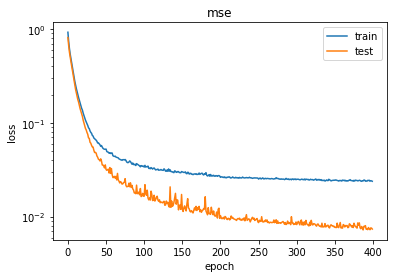

In [28]:
fig = plt.figure()
plt.semilogy(history.history['loss'])
if vsplit:
    plt.semilogy(history.history['val_loss'])
plt.title(loss_type)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Inference test

## prepare frontend for plotting

In [11]:
#@title import plotly
import plotly.plotly as py
import numpy as np
from plotly.offline import init_notebook_mode, iplot
# from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter
import plotly.graph_objs as go

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

## prepare data for plotting

## GPU data prepare

In [29]:
from sklearn.metrics import r2_score
# model.load_weights("./tmp/weights.best.cntk.hdf5")

x_test_df = pd.DataFrame(in_scaler.inverse_transform(x_test),columns=input_features)
y_test_df = pd.DataFrame(out_scaler.inverse_transform(y_test),columns=labels)

predict_val = model.predict(x_test,batch_size=1024*8)
predict_df = pd.DataFrame(out_scaler.inverse_transform(predict_val), columns=labels)

test_data=pd.concat([x_test_df,y_test_df],axis=1)
pred_data=pd.concat([x_test_df,predict_df],axis=1)

!rm sim_check.h5
test_data.to_hdf('sim_check.h5',key='test')
pred_data.to_hdf('sim_check.h5',key='pred')

df_test=pd.read_hdf('sim_check.h5',key='test')
df_pred=pd.read_hdf('sim_check.h5',key='pred')

zeta_level=list(set(df_test['zeta']))
zeta_level.sort()


res_sum=pd.DataFrame()
r2s=[]
r2s_i=[]

names=[]
maxs_0=[]
maxs_9=[]

for r2,name in zip(r2_score(df_test,df_pred,multioutput='raw_values'),df_test.columns):
  names.append(name)
  r2s.append(r2)
  maxs_0.append(df_test[df_test['zeta']==zeta_level[0]][name].max())
  maxs_9.append(df_test[df_test['zeta']==zeta_level[8]][name].max())
  for i in zeta_level:
    r2s_i.append(r2_score(df_pred[df_pred['zeta']==i][name],
                          df_test[df_test['zeta']==i][name]))

res_sum['name']=names
# res_sum['max_0']=maxs_0
# res_sum['max_9']=maxs_9
res_sum['z_scale']=[m_9/(m_0+1e-20) for m_9,m_0 in zip(maxs_9,maxs_0)]
# res_sum['r2']=r2s


tmp=np.asarray(r2s_i).reshape(23,10)
for idx,z in enumerate(zeta_level):
  res_sum['r2s_'+str(z)]=tmp[:,idx]

res_sum[3:]

,name,z_scale,r2s_0.0,r2s_0.11,r2s_0.22,r2s_0.33,r2s_0.44,r2s_0.55,r2s_0.66,r2s_0.77,r2s_0.88,r2s_0.99
3,H2O,0.223936,0.994692,0.996969,0.996717,0.997314,0.996900,0.997614,0.998130,0.993729,0.973362,0.542104
4,CH3,0.038082,0.993538,0.996836,0.997743,0.995564,0.994794,0.993882,0.994709,0.992570,0.974533,0.321455
5,NO2,0.018642,0.995092,0.992537,0.987351,0.986527,0.969689,0.968922,0.968380,0.967521,0.862214,0.094760
6,HCCOH,0.050377,0.991416,0.992390,0.996931,0.995593,0.996827,0.995321,0.995142,0.985903,0.973370,0.805990
7,C3H7,0.025454,0.989098,0.993468,0.991485,0.982011,0.981355,0.981362,0.988695,0.983415,0.945321,0.477793
8,HCN,0.013740,0.993721,0.992546,0.993990,0.990210,0.974505,0.988060,0.986927,0.986910,0.978820,0.606460
9,CO,0.181856,0.995349,0.996804,0.997401,0.998354,0.998212,0.998504,0.997892,0.995889,0.983960,0.628450
10,H,0.027857,0.988001,0.994952,0.995516,0.993222,0.993325,0.991780,0.992146,0.990224,0.977564,0.741665
11,CH2CHO,0.040537,0.987481,0.992649,0.993300,0.991837,0.990268,0.983807,0.984756,0.972782,0.932025,0.545822
12,NH3,0.013930,0.993308,0.988501,0.989973,0.987939,0.967048,0.984131,0.988346,0.979884,0.948907,0.272508


In [14]:
no_drop=res_sum[3:]
no_drop

,name,z_scale,r2s_0.0,r2s_0.11,r2s_0.22,r2s_0.33,r2s_0.44,r2s_0.55,r2s_0.66,r2s_0.77,r2s_0.88,r2s_0.99
3,H2O,0.025099,0.994348,0.996757,0.997679,0.997397,0.996234,0.996406,0.994271,0.991974,0.974852,0.540007
4,CH3,0.004408,0.993713,0.992451,0.990427,0.990768,0.991920,0.993102,0.989549,0.980553,0.962432,0.240307
5,NO2,0.002663,0.990074,0.987577,0.977061,0.970801,0.959147,0.960483,0.965934,0.950328,0.879216,0.221842
6,HCCOH,0.004557,0.980275,0.991997,0.990125,0.991279,0.991184,0.993769,0.990802,0.983833,0.949970,0.360558
7,C3H7,0.002971,0.989763,0.988398,0.974685,0.979987,0.977605,0.980510,0.974479,0.954326,0.917542,-0.141436
8,HCN,0.001617,0.986856,0.992629,0.991568,0.989211,0.977844,0.988155,0.986814,0.982518,0.956212,0.364831
9,CO,0.019751,0.995489,0.996940,0.997235,0.996935,0.996867,0.995047,0.993203,0.991182,0.975932,0.590335
10,H,0.002901,0.923382,0.995972,0.987720,0.989743,0.988857,0.990157,0.989224,0.988486,0.910302,0.322845
11,CH2CHO,0.004760,0.985648,0.984638,0.979977,0.984374,0.980879,0.974628,0.971772,0.972834,0.949861,0.100410
12,NH3,0.001544,0.991830,0.993470,0.984119,0.987192,0.966747,0.987275,0.986180,0.982362,0.958189,0.312757


## interactive plot

In [31]:
#@title Default title text
# species = np.random.choice(labels)
species = 'CO' #@param {type:"string"}
z_level = 8 #@param {type:"integer"}

# configure_plotly_browser_state()
# init_notebook_mode(connected=False)

from sklearn.metrics import r2_score


df_t=df_test[df_test['zeta']==zeta_level[z_level]].sample(frac=1)
# df_p=df_pred.loc[df_pred['zeta']==zeta_level[1]].sample(frac=0.1)
df_p=df_pred.loc[df_t.index]
error=df_p[species]-df_t[species]
r2=round(r2_score(df_p[species],df_t[species]),4)

print(species,'r2:',r2,'max:',df_t[species].max())

fig_db = {
    'data': [       
        {'name':'test data from table',
         'x': df_t['f'],
         'y': df_t['pv'],
         'z': df_t[species],
         'type':'scatter3d', 
        'mode': 'markers',
          'marker':{
              'size':1
          }
        },
        {'name':'prediction from neural networks',
         'x': df_p['f'],
         'y': df_p['pv'],
         'z': df_p[species],
         'type':'scatter3d', 
        'mode': 'markers',
          'marker':{
              'size':1
          },
        },
        {'name':'error in difference',
         'x': df_p['f'],
         'y': df_p['pv'],
         'z': error,
         'type':'scatter3d', 
         'mode': 'markers',
          'marker':{
              'size':1
          },
         }       
    ],
    'layout': {
        'scene':{
            'xaxis': {'title':'mixture fraction'},
            'yaxis': {'title':'progress variable'},
            'zaxis': {'title': species+'_r2:'+str(r2)}
                 }
    }
}
# iplot(fig_db, filename='multiple-scatter')
iplot(fig_db)


CO r2: 0.984 max: 0.018524


In [88]:
df_p['HNO']

KeyError: 'HNO'

In [89]:
%run -i k2tf.py --input_model='trained_fgm_nn.h5' --output_model='exported/fgm.pb'

E0106 17:24:29.382893 139753669891904 k2tf.py:82] Input file specified only holds the weights, and not the model definition. Save the model using model.save(filename.h5) which will contain the network architecture as well as its weights. If the model is saved using model.save_weights(filename), the flag input_model_json should also be set to the architecture which is exported separately in a json format. Check the keras documentation for more details (https://keras.io/getting-started/faq/)


ValueError: Unknown metric function:coeff_r2

<Figure size 432x288 with 0 Axes>